### In this experiment we used the training2017 dataset to perform a multi class classification using a 1‑D ResNet and applying focal loss to reduce class weight

Satisfactory results!!

In [32]:
###########################################
# 0. Imports
###########################################
# Core TensorFlow imports
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os, glob, random, math
from scipy.io import loadmat
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import confusion_matrix, classification_report

# Keras imports (for model building)
from tensorflow.keras.layers import (Input, Conv1D, BatchNormalization, ReLU,
                                     Add, GlobalAveragePooling1D, Dense, Dropout)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
import tensorflow.keras.backend as K


SEED = 42
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

# Manual Focal Loss
def focal_loss(gamma=2., alpha=.25):
    def focal_loss_fixed(y_true, y_pred):
        y_true = tf.one_hot(tf.cast(y_true, tf.int32), depth=4)  # <- One-hot encode
        epsilon = tf.keras.backend.epsilon()
        y_pred = tf.clip_by_value(y_pred, epsilon, 1. - epsilon)
        cross_entropy = -y_true * tf.math.log(y_pred)
        weight = alpha * tf.math.pow(1 - y_pred, gamma)
        loss = weight * cross_entropy
        return tf.reduce_sum(loss, axis=1)  # Reduce across classes
    return focal_loss_fixed



In [17]:
###########################################
# 1. Load and Preprocess ECG Data
###########################################
def load_physionet_metadata(data_path: str) -> pd.DataFrame:
    ref_file = os.path.join(data_path, "REFERENCE.csv")
    if not os.path.exists(ref_file):
        raise FileNotFoundError("REFERENCE.csv not found!")
    df = pd.read_csv(ref_file, header=None, names=["record", "label"])
    label_map = {"N": 0, "A": 1, "O": 2, "~": 3}
    df["y"] = df["label"].map(label_map)
    return df


In [41]:
# ---------------------------------------------------------------------
# 2. Signal I/O & preprocessing  --------------------------------------
# ---------------------------------------------------------------------

FS = 300  # Hz
WIN_SEC = 30            # 30‑s context
WIN_SAMPLES = WIN_SEC * FS
STEP = WIN_SAMPLES // 2  # 50 % overlap

def load_signal(mat_path: str) -> np.ndarray:
    """Returns a 1‑D float32 array."""
    mat = loadmat(mat_path)
    x = mat["val"][0].astype(np.float32)
    # z‑score normalisation per record
    x = (x - x.mean()) / (x.std() + 1e-7)
    return x

def segment_signal(x: np.ndarray, win: int = 9000, step: int = None) -> List[np.ndarray]:
    """
    Segment a 1-D signal into multiple windows of length `win`.
    If step is None, use non-overlapping segments.
    """
    if step is None:
        step = win
    if len(x) < win:
        # pad if too short
        pad = win - len(x)
        x = np.pad(x, (0, pad))
    segments = []
    for start in range(0, len(x) - win + 1, step):
        segment = x[start:start + win]
        segments.append(segment)
    return segments


In [42]:
# ---------------------------------------------------------------------
# 3. Data augmentation  ------------------------------------------------
# ---------------------------------------------------------------------

def augment_wave(seg: np.ndarray) -> np.ndarray:
    seg = seg.copy()
    # (a) 0‑mask random 50‑ms bursts
    burst_len = int(0.05 * FS)
    for _ in range(np.random.randint(1, 4)):
        s = np.random.randint(0, WIN_SAMPLES - burst_len)
        seg[s:s + burst_len] = 0.0
    # (b) amplitude scaling 0.9‑1.1
    seg *= np.random.uniform(0.9, 1.1)
    return seg

class SegmentGenerator(tf.keras.utils.Sequence):
    def __init__(self, X, y, batch_size=64, augment=False):
        self.X, self.y = X, y
        self.batch_size = batch_size
        self.augment = augment
        self.indices = np.arange(len(X))
        np.random.shuffle(self.indices)

    def __len__(self):
        return math.ceil(len(self.X) / self.batch_size)

    def __getitem__(self, idx):
        inds = self.indices[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_x = self.X[inds]
        if self.augment:
            batch_x = np.stack([augment_wave(x) for x in batch_x])
        batch_x = batch_x[..., np.newaxis]  # (batch_size, time_steps, 1)
        batch_y = self.y[inds]
        # Fix: convert both outputs into TensorFlow tensors
        batch_x = tf.convert_to_tensor(batch_x, dtype=tf.float32)
        batch_y = tf.convert_to_tensor(batch_y, dtype=tf.int32)
        return batch_x, batch_y

    def on_epoch_end(self):
        np.random.shuffle(self.indices)

In [46]:
# ---------------------------------------------------------------------
# 4. Model – 1‑D ResNet  ----------------------------------------------
# ---------------------------------------------------------------------

def res_block_sep(x, filters, stride=1, dil=1):
    shortcut = x
    x = tf.keras.layers.SeparableConv1D(filters, 9,
                                        padding='same',
                                        strides=stride,
                                        dilation_rate=dil)(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = tf.keras.layers.SeparableConv1D(filters, 9,
                                        padding='same',
                                        strides=1,
                                        dilation_rate=dil)(x)
    x = BatchNormalization()(x)

    if stride != 1 or shortcut.shape[-1] != filters:
        shortcut = Conv1D(filters, 1, strides=stride, padding='same')(shortcut)
    x = Add()([shortcut, x])
    return ReLU()(x)
def build_resnet_lite(input_len=4500, n_classes=4):
    inp = Input(shape=(input_len, 1))
    
    # Stem: downsample by stride=4, no dilation
    x = Conv1D(32, 9, strides=4, padding='same')(inp)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    # Lightweight residual blocks
    for f in [16, 32, 64]:
        x = res_block_sep(x, f, stride=2)
        x = res_block_sep(x, f)

    x = GlobalAveragePooling1D()(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.3)(x)
    out = Dense(n_classes, activation='softmax')(x)

    return Model(inp, out)

In [47]:
# ---------------------------------------------------------------------
# 5. Challenge metric (class‑weighted F1)  -----------------------------
# ---------------------------------------------------------------------

def challenge_f1(y_true, y_pred):
    y_pred = tf.argmax(y_pred, axis=-1)
    y_true = tf.cast(y_true, tf.int64)
    cm = tf.math.confusion_matrix(y_true, y_pred, num_classes=4)
    cm = tf.cast(cm, tf.float32)  # <-- Fix: cast here!!

    diag = tf.linalg.tensor_diag_part(cm)
    precision = diag / (tf.reduce_sum(cm, axis=0) + 1e-9)
    recall = diag / (tf.reduce_sum(cm, axis=1) + 1e-9)
    f1 = 2 * precision * recall / (precision + recall + 1e-9)
    return tf.reduce_mean(f1)

challenge_f1.__name__ = 'challenge_f1'

Total segments: 27919
Train / Val / Test shapes: (17822, 4500) (4522, 4500) (5575, 4500)


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8       │ (None, 4500, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_80 (Conv1D)  │ (None, 1125, 32)  │        320 │ input_layer_8[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1125, 32)  │        128 │ conv1d_80[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_66 (ReLU)     │ (None, 1125, 32)  │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv1d    │ (None, 563, 16)   │        816 │ re_lu_66[0][0]    │
│ (SeparableConv1D)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 563, 16)   │         64 │ separable_conv1d… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_67 (ReLU)     │ (None, 563, 16)   │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv1d_1  │ (None, 563, 16)   │        416 │ re_lu_67[0][0]    │
│ (SeparableConv1D)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_81 (Conv1D)  │ (None, 563, 16)   │        528 │ re_lu_66[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 563, 16)   │         64 │ separable_conv1d… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_30 (Add)        │ (None, 563, 16)   │          0 │ conv1d_81[0][0],  │
│                     │                   │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_68 (ReLU)     │ (None, 563, 16)   │          0 │ add_30[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv1d_2  │ (None, 563, 16)   │        416 │ re_lu_68[0][0]    │
│ (SeparableConv1D)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 563, 16)   │         64 │ separable_conv1d… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_69 (ReLU)     │ (None, 563, 16)   │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv1d_3  │ (None, 563, 16)   │        416 │ re_lu_69[0][0]    │
│ (SeparableConv1D)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 563, 16)   │         64 │ separable_conv1d… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_31 (Add)        │ (None, 563, 16)   │          0 │ re_lu_68[0][0],   │
│                     │                   │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_70 (ReLU)     │ (None, 563, 16)   │          0 │ add_31[0][0]    

 Total params: 33,236 (129.83 KB)

 Trainable params: 32,276 (126.08 KB)

 Non-trainable params: 960 (3.75 KB)

Epoch 1/30


/Users/macbookpro2017/project research/.venv/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


557/557 ━━━━━━━━━━━━━━━━━━━━ 26s 41ms/step - accuracy: 0.6056 - challenge_f1: 0.3225 - loss: 0.1035 - val_accuracy: 0.4912 - val_challenge_f1: 0.3804 - val_loss: 0.1124 - learning_rate: 6.6667e-04
Epoch 2/30
557/557 ━━━━━━━━━━━━━━━━━━━━ 23s 40ms/step - accuracy: 0.7233 - challenge_f1: 0.4735 - loss: 0.0631 - val_accuracy: 0.7477 - val_challenge_f1: 0.5428 - val_loss: 0.0586 - learning_rate: 0.0013
Epoch 3/30
557/557 ━━━━━━━━━━━━━━━━━━━━ 22s 40ms/step - accuracy: 0.7591 - challenge_f1: 0.5456 - loss: 0.0547 - val_accuracy: 0.7773 - val_challenge_f1: 0.5808 - val_loss: 0.0556 - learning_rate: 0.0020
Epoch 4/30
557/557 ━━━━━━━━━━━━━━━━━━━━ 23s 41ms/step - accuracy: 0.7842 - challenge_f1: 0.5887 - loss: 0.0466 - val_accuracy: 0.7979 - val_challenge_f1: 0.5965 - val_loss: 0.0452 - learning_rate: 0.0020
Epoch 5/30
557/557 ━━━━━━━━━━━━━━━━━━━━ 23s 41ms/step - accuracy: 0.7942 - challenge_f1: 0.6029 - loss: 0.0455 - val_accuracy: 0.7952 - val_challenge_f1: 0.5925 - val_loss: 0.0475 - learning_

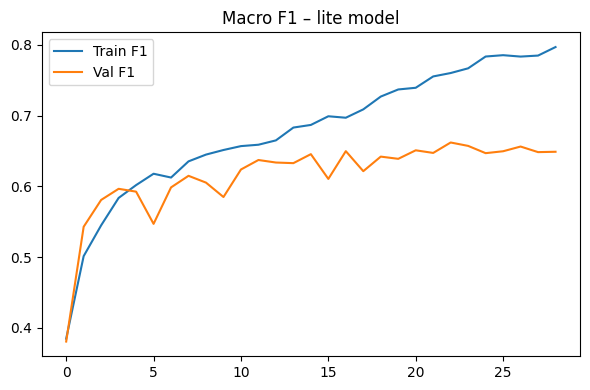

88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step

Confusion matrix:
[[3294    6   97    8]
 [   6  415   19    3]
 [ 437   76 1103   17]
 [   9    0    6   79]]

Classification report:
              precision    recall  f1-score   support

           0     0.8793    0.9674    0.9213      3405
           1     0.8350    0.9368    0.8830       443
           2     0.9004    0.6754    0.7719      1633
           3     0.7383    0.8404    0.7861        94

    accuracy                         0.8773      5575
   macro avg     0.8383    0.8550    0.8405      5575
weighted avg     0.8796    0.8773    0.8722      5575



In [48]:
# ---------------------------------------------------------------------
# 6. Main routine  -----------------------------------------------------
# ---------------------------------------------------------------------

if __name__ == "__main__":
    # -----------------------------------------------------------------
    # 6.0  Global window parameters for the lite model
    # -----------------------------------------------------------------
    FS        = 300          # Hz
    WIN_SEC   = 15           # 15-s context  ← shorter!
    WIN_SAMPLES = WIN_SEC * FS   # 4 500
    STEP      = WIN_SAMPLES // 2 # 50 % overlap

    # -----------------------------------------------------------------
    # 6.1  Load metadata & build segments
    # -----------------------------------------------------------------
    DATA_DIR = "training2017"
    meta = load_physionet_metadata(DATA_DIR)

    segments, labels, groups = [], [], []
    for rec, y in zip(meta.record, meta.y):
        x = load_signal(os.path.join(DATA_DIR, f"{rec}.mat"))
        for seg in segment_signal(x, win=WIN_SAMPLES, step=STEP):  # <-- pass new win/step
            segments.append(seg)
            labels.append(y)
            groups.append(rec)

    segments = np.stack(segments, dtype=np.float32)
    labels   = np.array(labels,  np.int32)
    groups   = np.array(groups)
    print("Total segments:", len(segments))

    # -----------------------------------------------------------------
    # 6.2  Patient-wise split
    # -----------------------------------------------------------------
    gss  = GroupShuffleSplit(test_size=0.2, n_splits=1, random_state=SEED)
    tr_i, te_i = next(gss.split(segments, labels, groups))
    gss2 = GroupShuffleSplit(test_size=0.2, n_splits=1, random_state=SEED)
    tr_i, va_i = next(gss2.split(segments[tr_i], labels[tr_i], groups[tr_i]))

    X_train, y_train = segments[tr_i], labels[tr_i]
    X_val,   y_val   = segments[va_i], labels[va_i]
    X_test,  y_test  = segments[te_i], labels[te_i]
    print("Train / Val / Test shapes:", X_train.shape, X_val.shape, X_test.shape)

    # -----------------------------------------------------------------
    # 6.3  Generators  (batch 32 is gentler on RAM/CPU)
    # -----------------------------------------------------------------
    BATCH = 32
    train_gen = SegmentGenerator(X_train, y_train, BATCH, augment=True)
    val_gen   = SegmentGenerator(X_val,   y_val,   BATCH, augment=False)

    # -----------------------------------------------------------------
    # 6.4  Build + compile lite ResNet
    # -----------------------------------------------------------------
    model = build_resnet_lite(input_len=WIN_SAMPLES, n_classes=4)
    model.compile(
        optimizer=Adam(2e-3),                   # a bit higher LR for smaller net
        loss=focal_loss(gamma=2.0, alpha=0.25), # same manual focal loss
        metrics=['accuracy', challenge_f1]
    )
    model.summary()

    # -----------------------------------------------------------------
    # 6.5  Warm-up → Cosine cooldown schedule (lighter than one-cycle)
    # -----------------------------------------------------------------
    def cosine_warmup(epoch):
        warm = 3
        total = 30
        if epoch < warm:
            return 2e-3 * (epoch + 1) / warm          # linear warm-up
        cos_inner = (epoch - warm) / (total - warm)
        return 2e-3 * 0.5 * (1 + np.cos(np.pi * cos_inner))

    cb_lr = tf.keras.callbacks.LearningRateScheduler(cosine_warmup)
    cb_es = tf.keras.callbacks.EarlyStopping(
        monitor='val_challenge_f1', patience=6, mode='max',
        restore_best_weights=True
    )

    # -----------------------------------------------------------------
    # 6.6  Train
    # -----------------------------------------------------------------
    history = model.fit(
        train_gen,
        epochs=30,
        validation_data=val_gen,
        callbacks=[cb_lr, cb_es],
        verbose=1
    )

    # -----------------------------------------------------------------
    # 6.7  Curves
    # -----------------------------------------------------------------
    plt.figure(figsize=(6,4))
    plt.plot(history.history['challenge_f1'],     label='Train F1')
    plt.plot(history.history['val_challenge_f1'], label='Val F1')
    plt.legend(); plt.title("Macro F1 – lite model"); plt.tight_layout(); plt.show()

    # -----------------------------------------------------------------
    # 6.8  Test evaluation
    # -----------------------------------------------------------------
    y_pred = np.argmax(model.predict(X_test[..., None], batch_size=64), axis=-1)
    print("\nConfusion matrix:")
    print(confusion_matrix(y_test, y_pred))
    print("\nClassification report:")
    print(classification_report(y_test, y_pred, digits=4))